In [139]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
from dataretrieval import nwis
from rasterio.crs import CRS
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
from sklearn import linear_model

import os

In [101]:
def cumulative_exceedence_pct(val: np.float64, series: pd.Series) -> np.float64:
  m = series > val
  return np.float64(len(series[m])/len(series))

In [243]:
cubic_ft_cumec_const = 0.0283168

# from Prof Allan Frei
watersheds_shp_fp = os.path.relpath("../datasets/watershed_bounds/basin24/basin24.shp")
watersheds_impermeability_fp = os.path.relpath("../datasets/out/watersheds_impermeability.geojson")
stream_gage_fp = os.path.relpath("../datasets/stream_gages/realstx_shp/realstx.shp")
stream_gage_out = os.path.relpath("../datasets/stream_gages/watershed_stream_gages.csv")
site_watersheds_fp = os.path.relpath("../datasets/out/stream_gage_watersheds_impermeability.geojson")

In [265]:
esopus_coldbrook_site = "01362500"
delaware_walton_site = "01423000"
e_croton_putnam_site = "0137449480"
w_croton_richardsville_site = "01374559"
# see https://help.waterdata.usgs.gov/code/parameter_cd_query?fmt=rdb&group_cd=PHY&inline=true
discharge_param_code = "00060" # ft3/s
peak_discharge_param_code = "62856" #ft3/s
# see https://help.waterdata.usgs.gov/stat_code
max_stat_code = "00001"
mean_stat_code = "00003"

In [103]:
watersheds_gdf = gpd.read_file(watersheds_shp_fp)
stream_gage_gdf = gpd.read_file(stream_gage_fp)

watersheds_gdf = watersheds_gdf.to_crs(stream_gage_gdf.crs if stream_gage_gdf.crs != None else CRS.from_epsg(4326))

stream_gages_in_watershed = stream_gage_gdf.sjoin(watersheds_gdf, how="inner")
stream_gages_in_watershed.explore()

In [ ]:
# sites upstream of reservoirs
upstream_site_ids = [
  "0142400103", # trout creek
  delaware_walton_site,
  "01422779", # West Brook Walton
  "01422747", # East Brook Walton
  "01421900", # West Branch Delaware Delhi, NY
  "01422500", # Little Delaware Delhi
  "01421610", # West Branch Delaware Hobart
  "01421618", # Town Brook Hobart
  "01350080", # Manor Kill Gilboa
  "01350035", # Bear Kill Prattsville
  "01349950", # Batavia Kill at Red Falls
  "01413500", # East Branch Delaware Margaretville
  "01414000", # Plattekill Dunraven
  "01365000", # Rondout Creek Lowes Corners
  "01365550", # Chestnut Creek Grahamsville
  "01363382", # Bush Kill West Shokan
  "01362200", # Esopus Creek at Allaben
  
  w_croton_richardsville_site,
  e_croton_putnam_site,
  "01374598", # Horse Pound Brook Carmel
  "01374781", # Titicus River Salem Center
  "01374890", # Cross River
]

In [104]:
def calc_relative_frequency(x: np.float64, vals: np.ndarray) -> np.float64:
    rank = vals <= x
    return np.float64(len(vals[rank])/(len(vals) + 1))

In [106]:
site_ids = list(stream_gages_in_watershed["STAID"].unique())

In [107]:
parameter_codes = [discharge_param_code, peak_discharge_param_code]
stat_codes = [mean_stat_code, max_stat_code]
raw_measurements_df, meta = nwis.get_dv(sites=site_ids, parameterCd=parameter_codes, start="1930-10-01", statCd=stat_codes)

In [206]:
peaks_df, meta = nwis.get_discharge_peaks(sites=site_ids, start="1930-10-01")
sites, meta = meta.site_info
peaks_df = peaks_df.dropna(subset="peak_va")

In [181]:
peak_va_sites = peaks_df.index.get_level_values(0).unique()
for site_id in peak_va_sites:
    vals = peaks_df.loc[(site_id), "peak_va"].values
    peaks_df.loc[(site_id), "rel_freq"] = np.array([calc_relative_frequency(x, vals=vals) for x in vals])
peaks_df["peak_cumecs"] = peaks_df["peak_va"] * cubic_ft_cumec_const
peaks_df["empirical_return_period"] = 1/(1-peaks_df["rel_freq"])
empirical_maximums = peaks_df.loc[:,["peak_va", "peak_cumecs", "empirical_return_period"]].groupby(level="site_no").agg(["max", "count"])
# perhaps do a kolmogoroff-smirnoff test to check the fit of the model


In [229]:
sites.explore()

In [241]:
# write stream metadata to csv
joining_meta = stream_gages_in_watershed.loc[:,["STAID", "BASIN"]].set_index("STAID")
sites.set_index("site_no").join(joining_meta).to_csv(stream_gage_out)

In [269]:
# we have the stream gages in the watershed, now we want the specific watershed for each
# stream gage. See `download_nldi_data.ipynb` and `watersheds.ipynb` for processing
site_watershed_raw_gdf = gpd.read_file(site_watersheds_fp).set_index("site_no")
site_watershed_raw_gdf


,basin_name,area_sq_miles,BASIN,watershed_area,year,impervious_fraction,geometry
site_no,,,,,,,
01349700,Schoharie 01349700,36.245518,Schoharie,catskill_delaware_outer,1985,0.005008,"POLYGON ((-74.09025 42.25915, -74.08524 42.258..."
01349700,Schoharie 01349700,36.245518,Schoharie,catskill_delaware_outer,1986,0.005011,"POLYGON ((-74.09025 42.25915, -74.08524 42.258..."
01349700,Schoharie 01349700,36.245518,Schoharie,catskill_delaware_outer,1987,0.005037,"POLYGON ((-74.09025 42.25915, -74.08524 42.258..."
01349700,Schoharie 01349700,36.245518,Schoharie,catskill_delaware_outer,1988,0.005044,"POLYGON ((-74.09025 42.25915, -74.08524 42.258..."
01349700,Schoharie 01349700,36.245518,Schoharie,catskill_delaware_outer,1989,0.005106,"POLYGON ((-74.09025 42.25915, -74.08524 42.258..."
...,...,...,...,...,...,...,...
01435900,Neversink 01435900,92.465974,Neversink,catskill_delaware_outer,2020,0.003262,"POLYGON ((-74.63862 41.82174, -74.64034 41.823..."
01435900,Neversink 01435900,92.465974,Neversink,catskill_delaware_outer,2021,0.003268,"POLYGON ((-74.63862 41.82174, -74.64034 41.823..."
01435900,Neversink 01435900,92.465974,Neversink,catskill_delaware_outer,2022,0.003268,"POLYGON ((-74.63862 41.82174, -74.64034 41.823..."


In [256]:
site_watershed_gdf = site_watershed_raw_gdf.groupby(by="site_no").agg({
  "basin_name": "first",
  "area_sq_miles": "first",
  "BASIN": "first",
  "watershed_area": "first",
  "geometry": "first",
  "impervious_fraction": "mean"
})

<Axes: xlabel='datetime', ylabel='peak_va'>

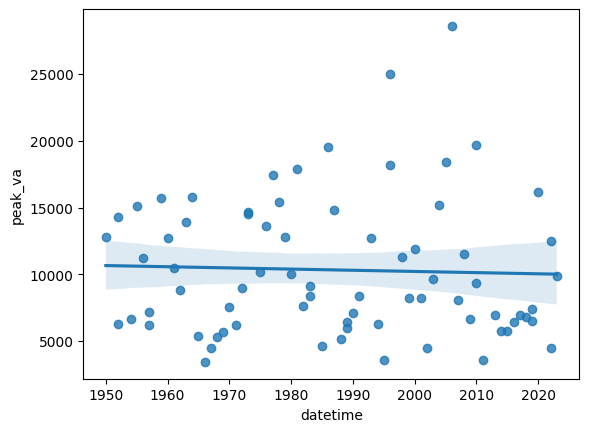

In [257]:
test_df = peaks_df.loc[(delaware_walton_site)].reset_index()
sns.regplot(data=test_df, x=test_df["datetime"].dt.year, y=test_df["peak_va"])

<Axes: xlabel='datetime', ylabel='peak_va'>

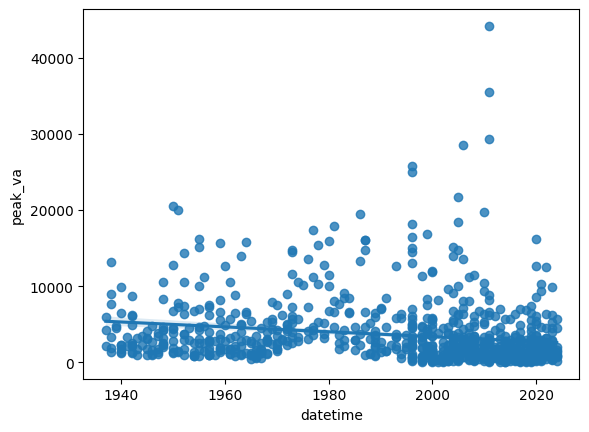

In [273]:
upstream_sites_df = peaks_df.loc[upstream_site_ids]
sns.regplot(data=upstream_sites_df, x=upstream_sites_df.index.get_level_values("datetime").year, y=upstream_sites_df["peak_va"])

In [258]:
peaks_df.loc[("01362232")]

,agency_cd,peak_tm,peak_va,peak_cd,gage_ht,gage_ht_cd,year_last_pk,ag_dt,ag_tm,ag_gage_ht,ag_gage_ht_cd
datetime,,,,,,,,,,,
2023-05-01 00:00:00+00:00,USGS,02:00,464.0,NaN,4.75,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-18 00:00:00+00:00,USGS,05:45,1320.0,NaN,6.15,NaN,NaN,NaN,NaN,NaN,NaN


In [285]:
# fit a regression model to our data with year as the independent var, and peak flow as dependent
# this essentially accounts for any trend over time, and eliminates change over time as a factor
# what we're trying to compare between watersheds is variance in peak flows.

# add year col for convenience
peaks_df.loc[:,"year"] = peaks_df.index.get_level_values("datetime").year

# what subset of the peaks data are we looking at
for site_id in peaks_df.index.get_level_values("site_no"):
  print(site_id, peaks_df.loc[(site_id)].shape)
  if peaks_df.loc[(site_id)].shape[0] < 3:
    # for some reason the regression doesn't like this
    continue
  mod = smf.ols("peak_va ~ year", data=peaks_df.loc[(site_id)])
  res = mod.fit()
  print(res.resid)
  # now, we want to get the residuals from our model, essentially the distance from
  # the trend line
  peaks_df.loc[(site_id), "residual"] = res.resid.values
  pred = res.get_prediction()
  peaks_df.loc[(site_id), "predicted_mean"] = pred.predicted_mean
  
  # print(res.summary())

peaks_df.loc[:, "normalized_residual"] = peaks_df.loc[:, "residual"] / peaks_df.loc[:, "predicted_mean"]


01349700 (40, 15)
datetime
1951-03-31 00:00:00+00:00     -477.777804
1955-10-16 00:00:00+00:00     3126.374644
1960-09-12 00:00:00+00:00     1274.065203
1965-08-14 00:00:00+00:00    -5598.244238
1966-03-25 00:00:00+00:00    -4924.706126
1967-04-01 00:00:00+00:00    -1621.168014
1968-03-18 00:00:00+00:00    -3747.629902
1972-06-22 00:00:00+00:00     3576.522545
1973-06-29 00:00:00+00:00     -859.939343
1973-12-21 00:00:00+00:00     2040.060657
1987-04-04 00:00:00+00:00     5679.594223
1996-01-19 00:00:00+00:00     8081.437229
1997-04-06 00:00:00+00:00    -4015.024659
1998-06-14 00:00:00+00:00    -2351.486547
1999-09-16 00:00:00+00:00     6582.051565
2000-06-07 00:00:00+00:00    -1144.410324
2000-12-17 00:00:00+00:00      505.589676
2002-03-27 00:00:00+00:00    -4614.334100
2003-09-28 00:00:00+00:00    -3383.795988
2004-09-18 00:00:00+00:00     -330.257876
2005-04-03 00:00:00+00:00     5683.280236
2005-11-30 00:00:00+00:00     -866.719764
2007-04-16 00:00:00+00:00       10.356459
2008-03

In [286]:
# now, find the variance in the residuals, as well as the slope of the trend
normalized_variance = peaks_df.loc[:, "normalized_residual"].groupby(level="site_no").agg(["var"])
normalized_variance

,var
site_no,
01349700,0.938433
01349705,0.329086
01349711,1.166651
01349810,1.091759
01349950,1.863097
...,...
01434017,0.268880
01434021,0.154430
01434025,0.398993


In [287]:
# join in some random info about the site
# TODO: include info about watershed, eg size and impermeable surfaces
variance_site_info = normalized_variance.join(
  sites.set_index("site_no"), how="left"
).join(
  site_watershed_gdf, how="left", lsuffix="_site", rsuffix="_site_watershed"
)
variance_site_info

,var,agency_cd,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,alt_datum_cd,huc_cd,geometry_site,basin_name,area_sq_miles,BASIN,watershed_area,geometry_site_watershed,impervious_fraction
site_no,,,,,,,,,,,,,,,,,,,
01349700,0.938433,USGS,EAST KILL NEAR JEWETT CENTER NY,ST,42.249167,-74.302778,S,NAD83,1451.65,0.01,NAVD88,2020005,POINT (-74.30278 42.24917),Schoharie 01349700,36.245518,Schoharie,catskill_delaware_outer,"POLYGON ((-74.09025 42.25915, -74.08524 42.258...",0.005744
01349705,0.329086,USGS,SCHOHARIE CREEK NEAR LEXINGTON NY,ST,42.236944,-74.340278,S,NAD83,1339.23,0.01,NAVD88,2020005,POINT (-74.34028 42.23694),Schoharie 01349705,101.781469,Schoharie,catskill_delaware_outer,"POLYGON ((-74.12597 42.11956, -74.12776 42.124...",0.010528
01349711,1.166651,USGS,WEST KILL BELOW HUNTER BROOK NEAR SPRUCETON NY,ST,42.185056,-74.277111,1,NAD83,2038.89,0.10,NAVD88,2020005,POINT (-74.27711 42.18506),Schoharie 01349711,31.397185,Schoharie,catskill_delaware_outer,"POLYGON ((-74.37291 42.17581, -74.38095 42.181...",0.003913
01349810,1.091759,USGS,WEST KILL NEAR WEST KILL NY,ST,42.230278,-74.393056,S,NAD83,1370.67,0.01,NGVD29,2020005,POINT (-74.39306 42.23028),Schoharie 01349810,31.397185,Schoharie,catskill_delaware_outer,"POLYGON ((-74.37291 42.17581, -74.38095 42.181...",0.003913
01349950,1.863097,USGS,BATAVIA KILL AT RED FALLS NEAR PRATTSVILLE NY,ST,42.308333,-74.390000,S,NAD83,1268.54,0.01,NAVD88,2020005,POINT (-74.39 42.30833),Schoharie 01349950,73.186323,Schoharie,catskill_delaware_outer,"POLYGON ((-74.27005 42.36762, -74.2664 42.3739...",0.011125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
01434017,0.268880,USGS,EAST BRANCH NEVERSINK RIVER NEAR CLARYVILLE NY,ST,41.925278,-74.540278,S,NAD83,1727.44,0.10,NAVD88,2040104,POINT (-74.54028 41.92528),Neversink 01434017,27.530241,Neversink,catskill_delaware_outer,"POLYGON ((-74.54364 41.90501, -74.54618 41.909...",0.002237
01434021,0.154430,USGS,W BR NEVERSINK R AT WINNISOOK L NR FROST VALLE...,ST,42.011111,-74.414444,S,NAD83,2675.00,0.01,NAVD88,2040104,POINT (-74.41444 42.01111),Neversink 01434021,3.360270,Neversink,catskill_delaware_outer,"POLYGON ((-74.43419 41.99186, -74.44274 41.998...",0.000852
01434025,0.398993,USGS,BISCUIT BK ABOVE PIGEON BK AT FROST VALLEY NY,ST,41.996083,-74.500222,1,NAD83,2057.25,0.09,NAVD88,2040104,POINT (-74.50022 41.99608),Neversink 01434025,3.841236,Neversink,catskill_delaware_outer,"POLYGON ((-74.48846 41.99703, -74.50007 41.992...",0.000000


<Axes: ylabel='Count'>

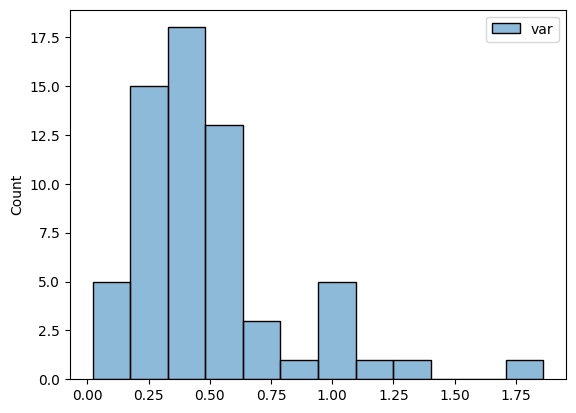

In [288]:
sns.histplot(data=normalized_variance)

<Axes: xlabel='area_sq_miles', ylabel='var'>

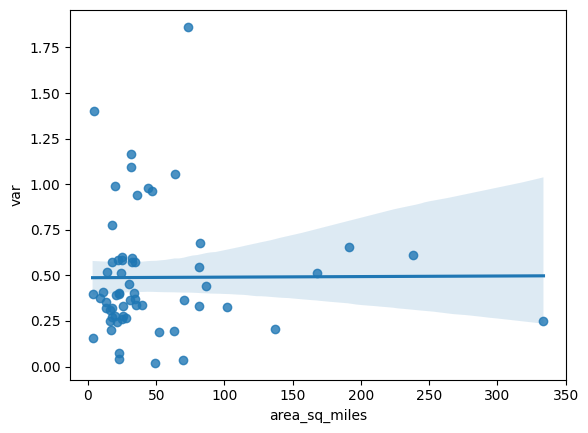

In [289]:
sns.regplot(data=variance_site_info, x="area_sq_miles", y="var")

<Axes: xlabel='impervious_fraction', ylabel='var'>

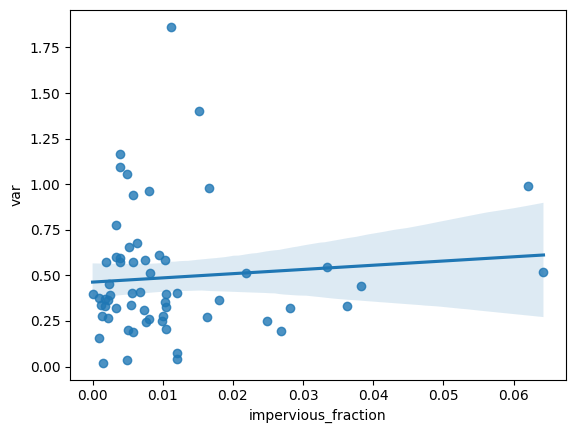

In [290]:
sns.regplot(data=variance_site_info, x="impervious_fraction", y="var")

In [293]:
model = smf.ols("var ~ impervious_fraction", data=variance_site_info)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    var   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.4735
Date:                Wed, 13 Aug 2025   Prob (F-statistic):              0.494
Time:                        20:16:06   Log-Likelihood:                -20.112
No. Observations:                  62   AIC:                             44.22
Df Residuals:                      60   BIC:                             48.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.4632    

### Scratch pad, testing peaks for individual stations

In [111]:
# use delaware walton site for testing some things out
delaware_walton_peaks, meta = nwis.get_discharge_peaks(sites=delaware_walton_site, start="1930-10-01")
# calculate F(X)
#   empirical probability of a flow being less than X
delaware_walton_peaks["rel_freq"] = delaware_walton_peaks["peak_va"].apply(lambda x: calc_relative_frequency(x, delaware_walton_peaks["peak_va"]))
delaware_walton_peaks["peak_cumecs"] = delaware_walton_peaks["peak_va"] * cubic_ft_cumec_const


In [112]:
# use delaware walton site for testing some things out
e_croton_putnam, meta = nwis.get_discharge_peaks(sites=e_croton_putnam_site, start="1930-10-01")
# calculate F(X)
#   empirical probability of a flow being less than X
e_croton_putnam["rel_freq"] = e_croton_putnam["peak_va"].apply(lambda x: calc_relative_frequency(x, e_croton_putnam["peak_va"]))
e_croton_putnam["peak_cumecs"] = e_croton_putnam["peak_va"] * cubic_ft_cumec_const

In [113]:
# use delaware walton site for testing some things out
w_croton_richardsville, meta = nwis.get_discharge_peaks(sites=w_croton_richardsville_site, start="1930-10-01")
# calculate F(X)
#   empirical probability of a flow being less than X
w_croton_richardsville["rel_freq"] = w_croton_richardsville["peak_va"].apply(lambda x: calc_relative_frequency(x, w_croton_richardsville["peak_va"]))
w_croton_richardsville["peak_cumecs"] = w_croton_richardsville["peak_va"] * cubic_ft_cumec_const

### Method of Moments Analysis on each site's peaks

```
F(X) = e^(-e^(-b(X-a)))
a = mean(Q) - 0.5772/b
b = pi/(standard deviation of Q*sqrt(6))

X = a - 1/b*ln(ln(T(X)/T(X-1)))
```

This gives us a probabalistic flow or relative frequency for given flow based on the Gumbel distribution. This is from the textbook *Fundamentals of Hydrology (2nd ed)* by Tim Davie.

Another option, one that seems to be the standard, would be Log-Pearson Type 3 distribution, described [here](https://streamflow.engr.oregonstate.edu/analysis/floodfreq/)

In [ ]:
moment_calcs = peaks_df.loc[:,"peak_va"].groupby(level="site_no").agg(["mean",  "std"])
moment_calcs["b"] = np.pi/(moment_calcs["std"]*np.sqrt(6))
moment_calcs["a"] = moment_calcs["mean"]-(np.float64(0.5772)/moment_calcs["b"])
moment_calcs

years_to_calc = [2, 5, 10, 25, 50, 100]
return_period_idx = pd.MultiIndex.from_product([moment_calcs.index, years_to_calc], names=["site_no", "return_period"])
return_period_df = return_period_idx.to_frame()
# this should be easy with vectorized functions but I can't figure out how!
for moment in moment_calcs.itertuples():
    for year in years_to_calc + [empirical_maximums.loc[moment.Index, ("empirical_return_period", "max")]]:
        return_period_df.loc[(moment.Index, year), "flow"] = moment.a - (1/moment.b) * np.log(np.log(year/(year-1)))

return_period_df["flow_cumecs"] = return_period_df["flow"] * cubic_ft_cumec_const
return_period_df.loc[[(delaware_walton_site),(w_croton_richardsville_site)], "flow_cumecs"]

C:\Users\Kiron\AppData\Local\Temp\ipykernel_28956\1909719848.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return_period_df.loc[(moment.Index, year), "flow"] = moment.a - (1/moment.b) * np.log(np.log(year/(year-1)))
C:\Users\Kiron\AppData\Local\Temp\ipykernel_28956\1909719848.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return_period_df.loc[(moment.Index, year), "flow"] = moment.a - (1/moment.b) * np.log(np.log(year/(year-1)))


site_no   return_period
01423000  2.0              268.517299
          5.0              397.130339
          10.0             482.283363
          25.0             589.874434
          50.0             669.691637
          100.0            748.919482
          75.0             716.084438
01374559  2.0                9.676061
          5.0               16.039910
          10.0              20.253332
          25.0              25.577001
          50.0              29.526404
          100.0             33.446644
          30.0              26.619989
Name: flow_cumecs, dtype: float64

In [127]:
empirical_maximums.loc[[delaware_walton_site, w_croton_richardsville_site]]

peak_va       peak_cumecs       empirical_return_period      
              max count         max count                     max count
site_no                                                                
01423000  28600.0    74  809.860480    74                    75.0    74
01374559   1290.0    29   36.528672    29                    30.0    29

### Plot various characteristics at different sites

<Axes: xlabel='return_period', ylabel='flow_cumecs'>

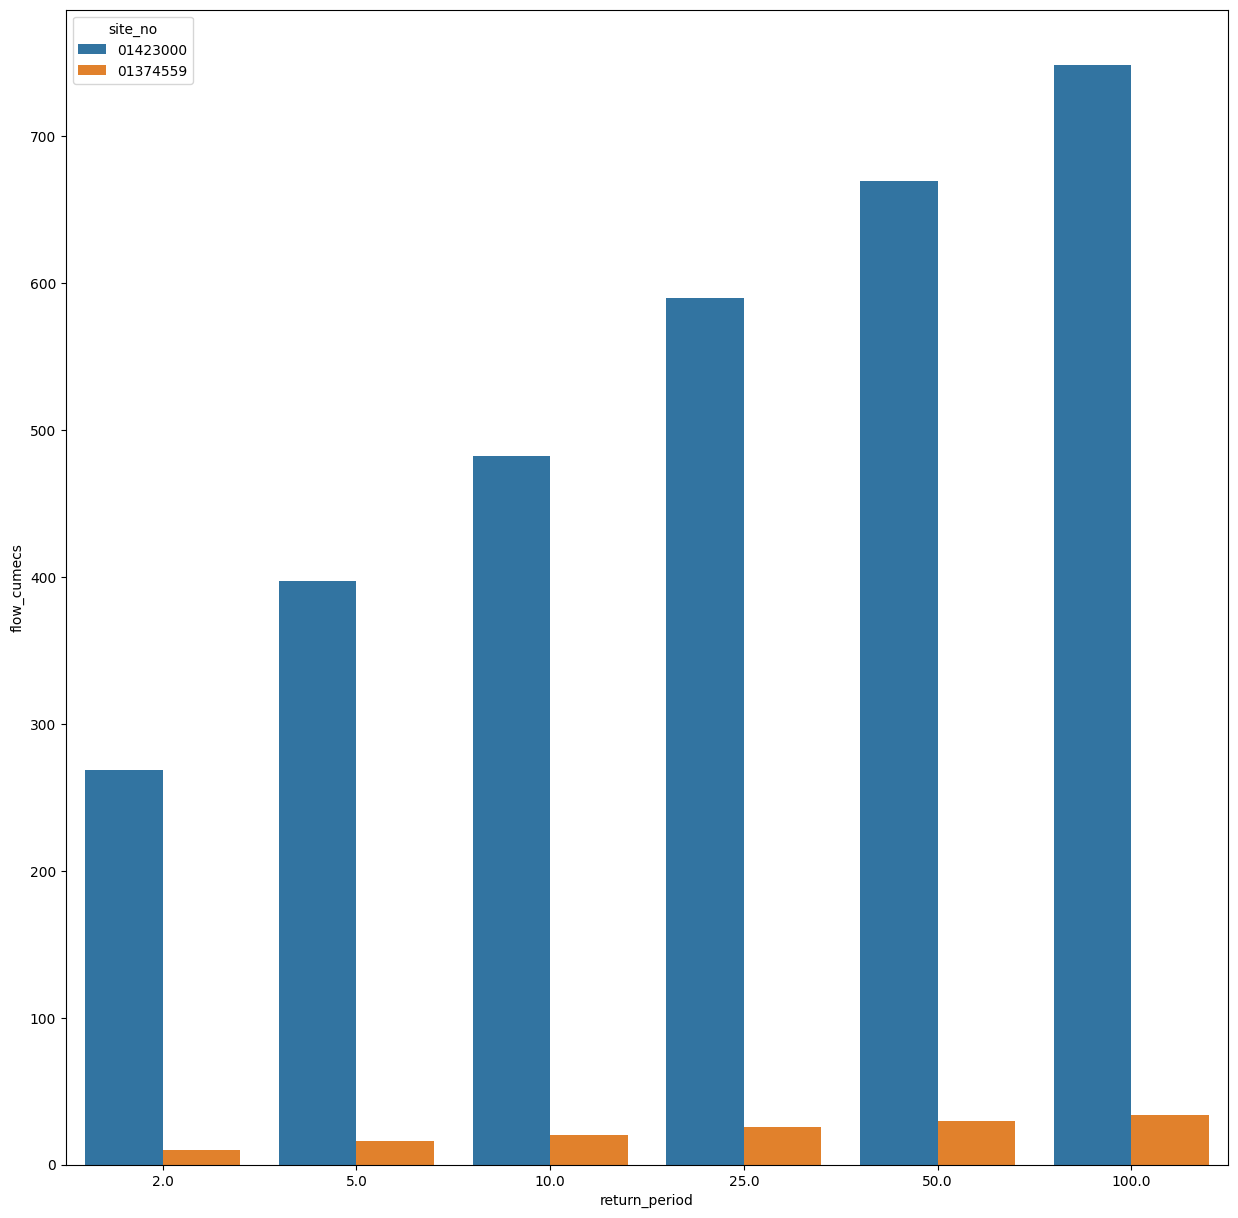

In [124]:
fig, ax = plt.subplots(figsize=(15,15))

# sns.lineplot(data=delaware_walton_peaks, x="peak_cumecs", y="rel_freq", ax=ax)
# sns.lineplot(data=e_croton_putnam, x="peak_cumecs", y="rel_freq", ax=ax)
# sns.lineplot(data=w_croton_richardsville, x="peak_cumecs", y="rel_freq", ax=ax)
# sns.barplot(data=peaks_df.loc[(delaware_walton_site)], y="peak_cumecs", x="empirical_return_period")
sns.barplot(data=return_period_df.loc[[(delaware_walton_site), (w_croton_richardsville_site)], ["site_no", "return_period", "flow_cumecs"]], x="return_period", y="flow_cumecs", hue="site_no")
# sns.lineplot(data=peaks_df.loc[(delaware_walton_site)], x="peak_cumecs", y="rel_freq", ax=ax)

In [135]:
raw_measurements_df

00060_Mean 00060_Mean_cd
site_no  datetime                                           
01349700 1996-12-27 00:00:00+00:00       119.0             A
         1996-12-28 00:00:00+00:00       103.0             A
         1996-12-29 00:00:00+00:00       143.0             A
         1996-12-30 00:00:00+00:00       185.0             A
         1996-12-31 00:00:00+00:00       123.0             A
...                                        ...           ...
01435000 2025-08-03 00:00:00+00:00        72.8             P
         2025-08-04 00:00:00+00:00        68.5             P
         2025-08-05 00:00:00+00:00        66.2             P
         2025-08-06 00:00:00+00:00        64.3             P
         2025-08-07 00:00:00+00:00        67.4             P

[831182 rows x 2 columns]

In [109]:
raw_measurements_df.index.to_frame()

site_no                  datetime
site_no  datetime                                                     
01349700 1996-12-27 00:00:00+00:00  01349700 1996-12-27 00:00:00+00:00
         1996-12-28 00:00:00+00:00  01349700 1996-12-28 00:00:00+00:00
         1996-12-29 00:00:00+00:00  01349700 1996-12-29 00:00:00+00:00
         1996-12-30 00:00:00+00:00  01349700 1996-12-30 00:00:00+00:00
         1996-12-31 00:00:00+00:00  01349700 1996-12-31 00:00:00+00:00
...                                      ...                       ...
01435000 2025-08-03 00:00:00+00:00  01435000 2025-08-03 00:00:00+00:00
         2025-08-04 00:00:00+00:00  01435000 2025-08-04 00:00:00+00:00
         2025-08-05 00:00:00+00:00  01435000 2025-08-05 00:00:00+00:00
         2025-08-06 00:00:00+00:00  01435000 2025-08-06 00:00:00+00:00
         2025-08-07 00:00:00+00:00  01435000 2025-08-07 00:00:00+00:00

[831182 rows x 2 columns]

In [ ]:
# clean/remove invalid vals
m = raw_measurements_df["00060_Mean"] >= 0
stream_gage_measurements = pd.concat([raw_measurements_df[m], raw_measurements_df.index.to_frame()], axis=1).dropna()
stream_gage_measurements = stream_gage_measurements.rename({"site_no": "site_number"}, axis=1)

# convert to m3/s (aka) cumec
stream_gage_measurements["mean_cumec"] = stream_gage_measurements["00060_Mean"] * cubic_ft_cumec_const

# add useful date cols
# stream_gage_measurements["datetime"] = stream_gage_measurements.index[1]
# stream_gage_measurements["site_no"] = stream_gage_measurements.index[0]
stream_gage_measurements["year"] = stream_gage_measurements["datetime"].dt.year
stream_gage_measurements["month"] = stream_gage_measurements["datetime"].dt.month
stream_gage_measurements["day_of_year"] = stream_gage_measurements["datetime"].dt.day_of_year
stream_gages_watersheds = pd.merge(left=stream_gage_measurements, right=stream_gages_in_watershed, left_on="site_number", right_on="STAID", how="left")

c:\Users\kroy\projects\nyc_water_supply_analysis\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


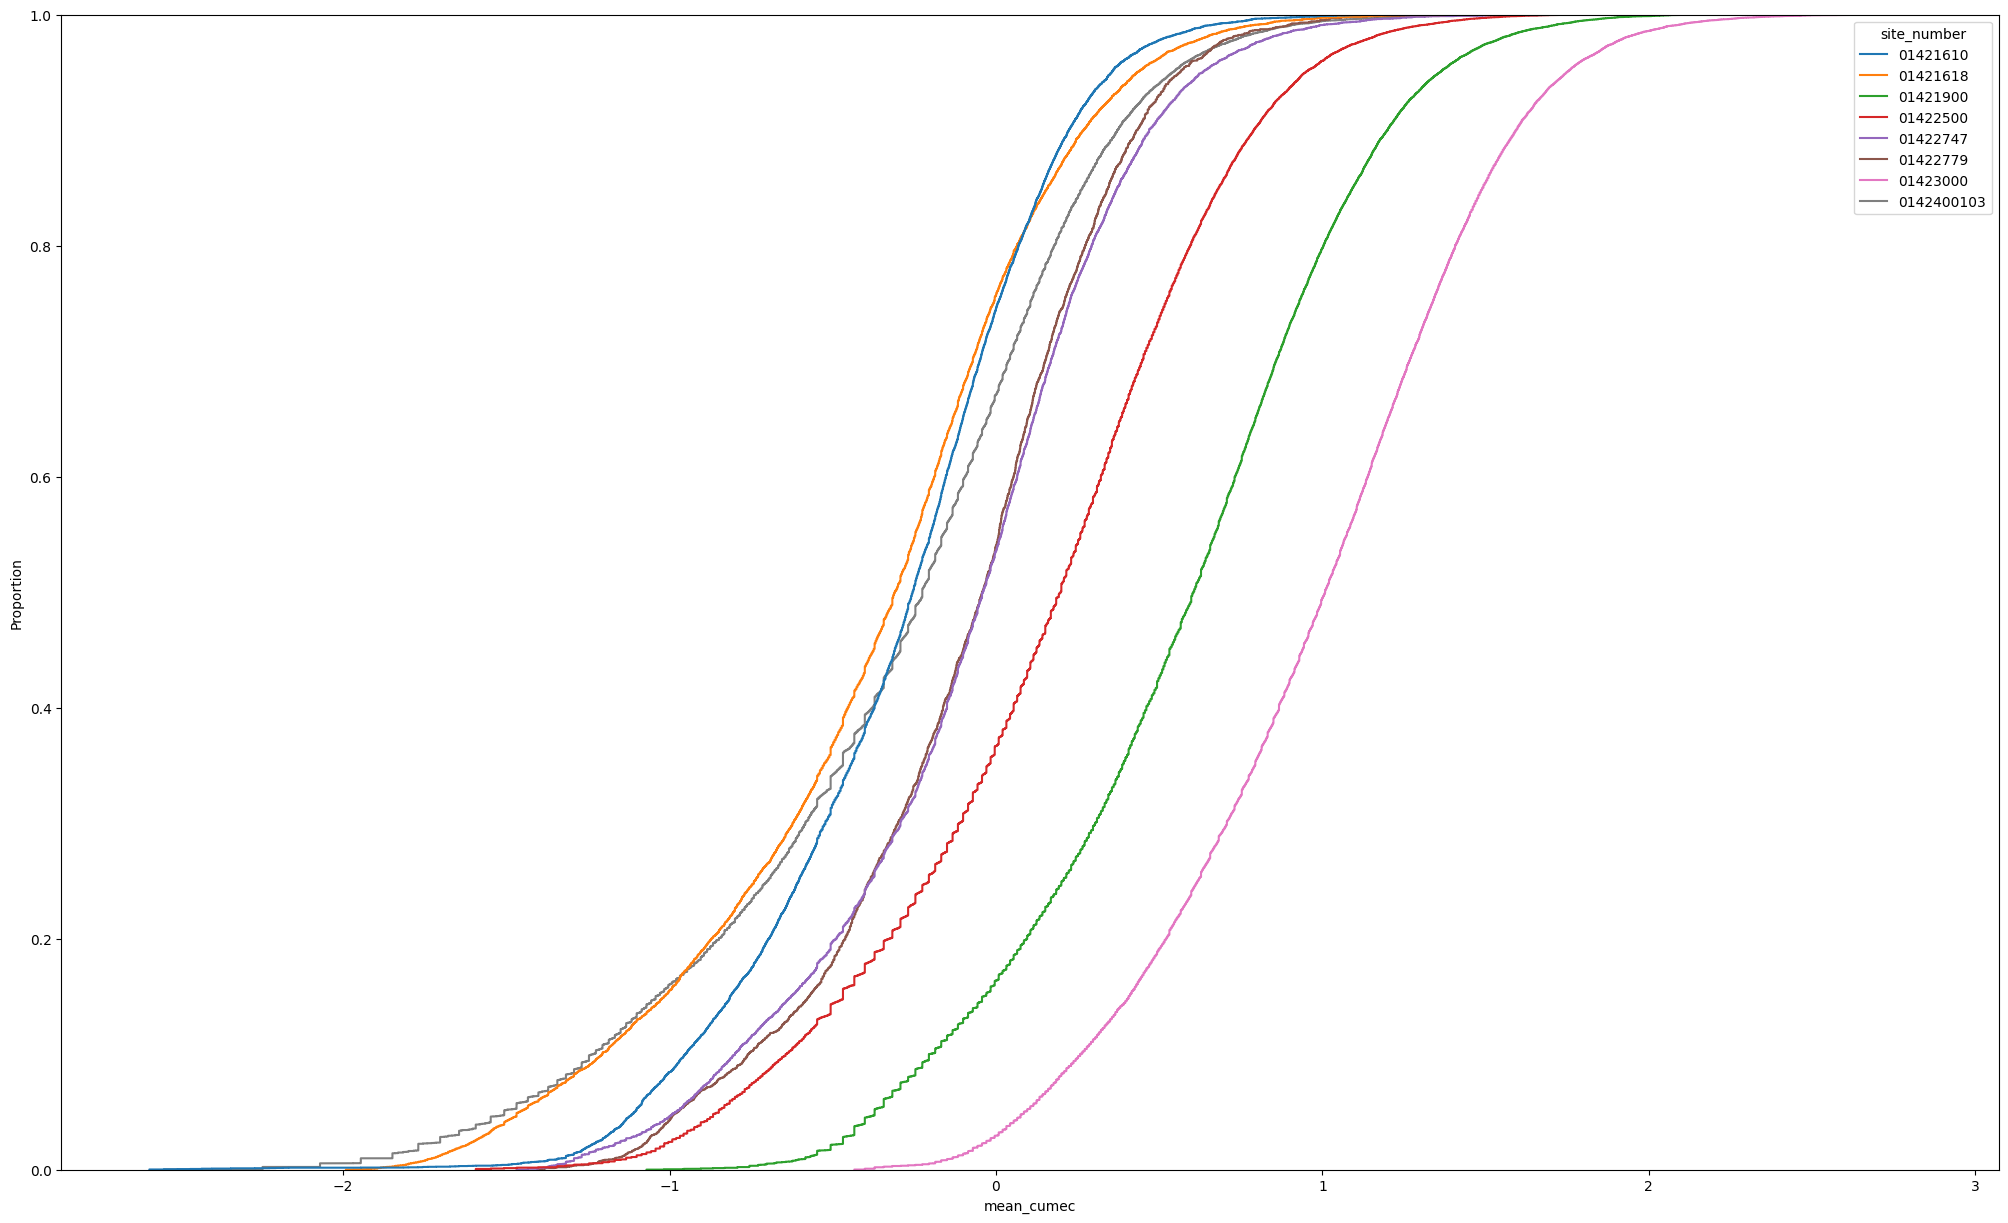

In [160]:
g = sns.ecdfplot(data=stream_gages_watersheds[stream_gages_watersheds["BASIN"] == "Cannonsville"], x=np.log10(stream_gages_watersheds["mean_cumec"]), hue="site_number")
g.figure.set_size_inches(25,15)

<Axes: xlabel='day_of_year', ylabel='mean_cumec'>

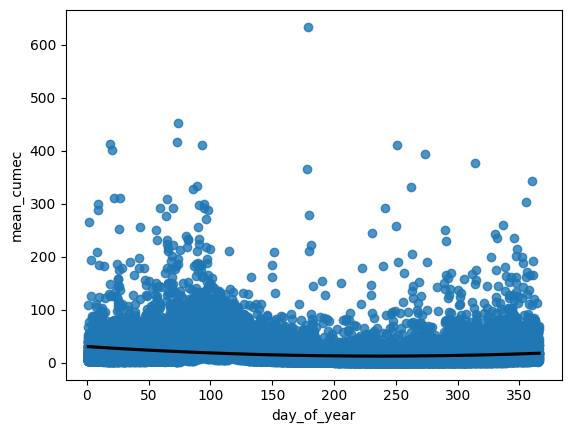

In [132]:
sns.regplot(data=stream_gage_measurements.loc[("01423000")], x="day_of_year", y="mean_cumec", order=2, line_kws={"color":"black"})

In [73]:
measurements_df, meta = nwis.get_discharge_measurements(sites=esopus_coldbrook_site, start="2017-11-01")
measurements_df

,agency_cd,site_no,measurement_nu,measurement_dt,tz_cd,q_meas_used_fg,party_nm,site_visit_coll_agency_cd,gage_height_va,discharge_va,measured_rating_diff,gage_va_change,gage_va_time,control_type_cd,discharge_cd
0,USGS,01362500,987,2017-12-20 14:58:05,EST,Yes,TFH/KCS,USGS,4.72,476.0,Fair,NaN,NaN,Clear,NONE
1,USGS,01362500,988,2018-02-13 08:36:55,EST,Yes,TFH/BRH,USGS,5.62,1110.0,Fair,NaN,NaN,Clear,NONE
2,USGS,01362500,989,2018-04-12 13:44:45,EST,Yes,TFH/BRH,USGS,4.63,463.0,Fair,NaN,NaN,Clear,NONE
3,USGS,01362500,990,2018-06-07 11:15:41,EST,Yes,BRH,USGS,4.43,354.0,Good,0.00,0.25,Clear,NONE
4,USGS,01362500,991,2018-08-14 09:51:45,EST,Yes,TFH/JAA,USGS,8.22,3970.0,Fair,0.04,NaN,Clear,NONE
5,USGS,01362500,992,2018-10-24 12:41:21,EST,Yes,TFH/BRH,USGS,4.12,243.0,Fair,NaN,NaN,Clear,NONE
6,USGS,01362500,993,2018-12-14 11:32:37,EST,Yes,cim,USGS,4.42,347.0,Fair,NaN,NaN,Clear,NONE
7,USGS,01362500,994,2019-03-19 13:24:41,EST,Yes,cim,USGS,4.67,491.0,Fair,NaN,NaN,Clear,NONE
8,USGS,01362500,995,2019-05-01 10:27:17,EST,Yes,cim,USGS,5.18,763.0,Good,NaN,NaN,Clear,NONE
9,USGS,01362500,996,2019-07-17 11:39:41,EST,Yes,CIM,USGS,4.38,342.0,Good,NaN,NaN,Clear,NONE


In [ ]:
esopus_coldbrook_df, meta = nwis.get_dv(sites=esopus_coldbrook_site, parameterCd=parameter_codes, start="1931-10-01", statCd=stat_codes)
esopus_coldbrook_df

,site_no,00060_Mean,00060_Mean_cd
datetime,,,
1931-10-01 00:00:00+00:00,01362500,49.0,A
1931-10-02 00:00:00+00:00,01362500,49.0,A
1931-10-03 00:00:00+00:00,01362500,49.0,A
1931-10-04 00:00:00+00:00,01362500,46.0,A
1931-10-05 00:00:00+00:00,01362500,46.0,A
...,...,...,...
2025-08-01 00:00:00+00:00,01362500,439.0,P
2025-08-02 00:00:00+00:00,01362500,427.0,P
2025-08-03 00:00:00+00:00,01362500,409.0,P


In [87]:
parameter_codes = [discharge_param_code]
stat_codes = [mean_stat_code]
delaware_walton_df_raw, meta = nwis.get_dv(sites=delaware_walton_site, parameterCd=parameter_codes, start="1950-10-01", statCd=stat_codes)
delaware_walton_df_raw

,site_no,00060_Mean,00060_Mean_cd
datetime,,,
1950-10-01 00:00:00+00:00,01423000,108.0,A
1950-10-02 00:00:00+00:00,01423000,105.0,A
1950-10-03 00:00:00+00:00,01423000,102.0,A
1950-10-04 00:00:00+00:00,01423000,99.0,A
1950-10-05 00:00:00+00:00,01423000,95.0,A
...,...,...,...
2025-08-01 00:00:00+00:00,01423000,170.0,"P, e"
2025-08-02 00:00:00+00:00,01423000,125.0,"P, e"
2025-08-03 00:00:00+00:00,01423000,104.0,"P, e"


In [89]:
# clean/remove invalid vals
m = delaware_walton_df_raw["00060_Mean"] >= 0
delaware_walton_df = delaware_walton_df_raw[m]

# convert to m3/s
delaware_walton_df["daily_mean_discharge_metric"] = delaware_walton_df["00060_Mean"] * 0.0283168

# add useful date cols
delaware_walton_df["datetime"] = delaware_walton_df.index
delaware_walton_df["year"] = delaware_walton_df["datetime"].dt.year
delaware_walton_df["month"] = delaware_walton_df["datetime"].dt.month
delaware_walton_df["day_of_year"] = delaware_walton_df["datetime"].dt.day_of_year
delaware_walton_df

,site_no,00060_Mean,00060_Mean_cd,daily_mean_discharge_metric,datetime,year,month,day_of_year
datetime,,,,,,,,
1950-10-01 00:00:00+00:00,01423000,108.0,A,3.058214,1950-10-01 00:00:00+00:00,1950,10,274
1950-10-02 00:00:00+00:00,01423000,105.0,A,2.973264,1950-10-02 00:00:00+00:00,1950,10,275
1950-10-03 00:00:00+00:00,01423000,102.0,A,2.888314,1950-10-03 00:00:00+00:00,1950,10,276
1950-10-04 00:00:00+00:00,01423000,99.0,A,2.803363,1950-10-04 00:00:00+00:00,1950,10,277
1950-10-05 00:00:00+00:00,01423000,95.0,A,2.690096,1950-10-05 00:00:00+00:00,1950,10,278
...,...,...,...,...,...,...,...,...
2025-08-01 00:00:00+00:00,01423000,170.0,"P, e",4.813856,2025-08-01 00:00:00+00:00,2025,8,213
2025-08-02 00:00:00+00:00,01423000,125.0,"P, e",3.539600,2025-08-02 00:00:00+00:00,2025,8,214
2025-08-03 00:00:00+00:00,01423000,104.0,"P, e",2.944947,2025-08-03 00:00:00+00:00,2025,8,215


In [93]:
binned, bins = pd.cut(delaware_walton_df["daily_mean_discharge_metric"], 20, retbins=True)
delaware_walton_df["bin"] = binned

In [97]:
delaware_walton_df["cumulative_freq_exceedence"] = delaware_walton_df["00060_Mean"].apply(lambda x: cumulative_exceedence_pct(x, delaware_walton_df["00060_Mean"]))
# delaware_walton_df["cumulative_freq"] = delaware_walton_df["00060_Mean"]

In [53]:
delaware_walton_df

,site_no,00060_Mean,00060_Mean_cd,daily_mean_discharge_metric,cumulative_freq_exceedence
datetime,,,,,
1950-10-01 00:00:00+00:00,01423000,108.0,A,3.058214,0.815299
1950-10-02 00:00:00+00:00,01423000,105.0,A,2.973264,0.820822
1950-10-03 00:00:00+00:00,01423000,102.0,A,2.888314,0.825797
1950-10-04 00:00:00+00:00,01423000,99.0,A,2.803363,0.831943
1950-10-05 00:00:00+00:00,01423000,95.0,A,2.690096,0.839808
...,...,...,...,...,...
2025-07-30 00:00:00+00:00,01423000,115.0,"P, e",3.256432,0.803263
2025-07-31 00:00:00+00:00,01423000,127.0,"P, e",3.596234,0.781314
2025-08-01 00:00:00+00:00,01423000,173.0,P,4.898806,0.708443


In [95]:
delaware_walton_df.groupby(by="bin").count()

C:\Users\Kiron\AppData\Local\Temp\ipykernel_28956\3502212858.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  delaware_walton_df.groupby(by="bin").count()


,site_no,00060_Mean,00060_Mean_cd,daily_mean_discharge_metric,datetime,year,month,day_of_year
bin,,,,,,,,
"(-0.266, 32.065]",23474,23474,23474,23474,23474,23474,23474,23474
"(32.065, 63.761]",2823,2823,2823,2823,2823,2823,2823,2823
"(63.761, 95.457]",623,623,623,623,623,623,623,623
"(95.457, 127.154]",198,198,198,198,198,198,198,198
"(127.154, 158.85]",91,91,91,91,91,91,91,91
"(158.85, 190.547]",50,50,50,50,50,50,50,50
"(190.547, 222.243]",27,27,27,27,27,27,27,27
"(222.243, 253.939]",17,17,17,17,17,17,17,17
"(253.939, 285.636]",8,8,8,8,8,8,8,8


<Axes: xlabel='bin', ylabel='daily_mean_discharge_metric'>

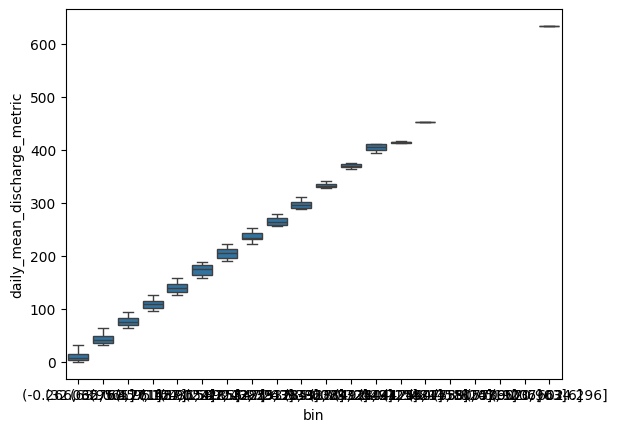

In [94]:
sns.boxplot(delaware_walton_df, x="bin", y="daily_mean_discharge_metric")

<Axes: xlabel='cumulative_freq_exceedence', ylabel='daily_mean_discharge_metric'>

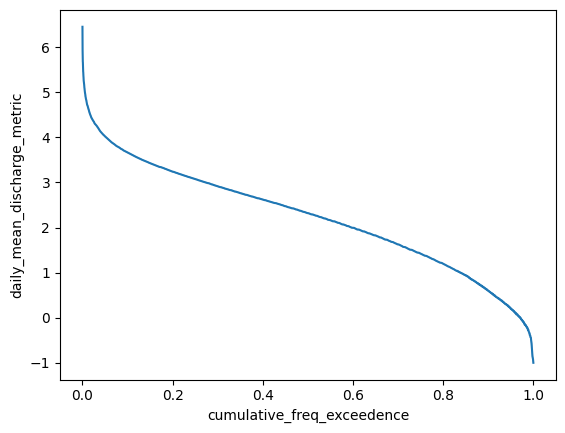

In [98]:
sns.lineplot(data=delaware_walton_df, y=np.log(delaware_walton_df["daily_mean_discharge_metric"]), x="cumulative_freq_exceedence")

<Axes: xlabel='day_of_year', ylabel='daily_mean_discharge_metric'>

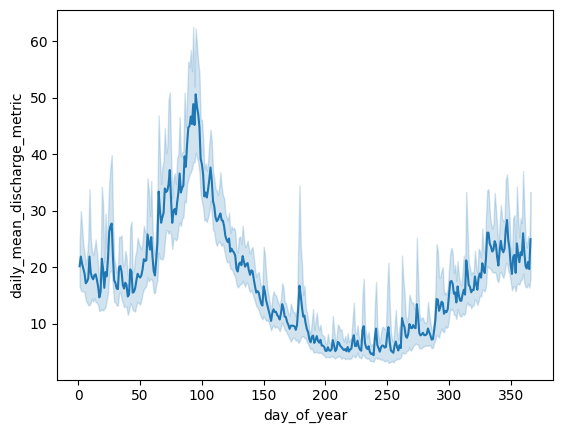

In [99]:
sns.lineplot(data=delaware_walton_df, x="day_of_year", y="daily_mean_discharge_metric")

<Axes: ylabel='Count'>

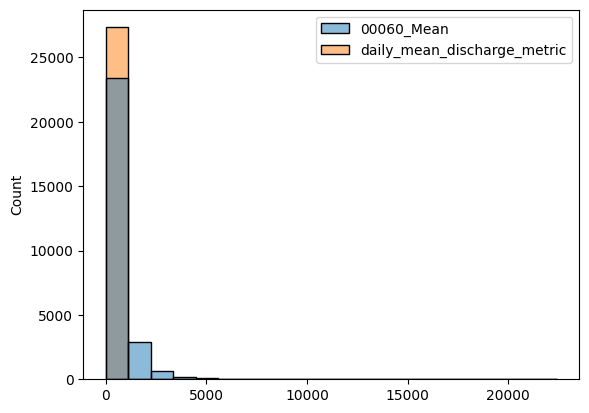

In [41]:
sns.histplot(data=delaware_walton_df, bins=20)

KeyboardInterrupt: 

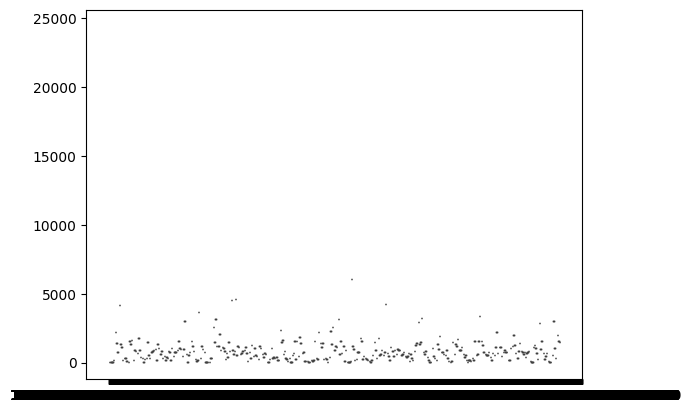

In [16]:
sns.boxplot(data=esopus_coldbrook_df, x=esopus_coldbrook_df.index, y="00060_Mean")